# Paths for  Heston - Euler scheme vs Almost exact simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 

In [5]:
# This uses Euler scheme to simulate the Heston model for X = log(S)
def GeneratePathsHestonEuler(NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0, NoOfPaths = 1):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    
    V[:,0] = v0
    X[:,0] = np.log(S_0)
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    
    for i in range(0,NoOfSteps):

        # Making sure that samples from a normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
            
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Truncated boundary condition
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        V[:,i+1] = np.maximum(V[:,i+1],0.0)
        
        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])
        
        time[i+1] = time[i] +dt
        
    # Compute exponent

    S = np.exp(X)
    paths = {"time":time,"S":S}
    
    return paths

In [3]:
# This applies the AE scheme by sampling from a chi-squared distribution
def CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    
    delta = 4.0 *kappa*vbar/gamma/gamma
    c = 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    
    return  sample

def GeneratePathsHestonAES(NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0, NoOfPaths = 1):    
    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    
    for i in range(0,NoOfSteps):

        # making sure that samples from a normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        
        # Exact samples for the variance process
        V[:,i+1] = CIR_Sample(NoOfPaths,kappa,gamma,vbar,0,dt,V[:,i])
        
        k0 = (r -rho/gamma*kappa*vbar)*dt
        k1 = (rho*kappa/gamma -0.5)*dt - rho/gamma
        k2 = rho / gamma
        
        X[:,i+1] = X[:,i] + k0 + k1*V[:,i] + k2 *V[:,i+1] + np.sqrt((1.0-rho**2)*V[:,i])*(W1[:,i+1]-W1[:,i])
        
        time[i+1] = time[i] +dt
        
    # Compute exponent

    S = np.exp(X)
    paths = {"time":time,"S":S}
    
    return paths

In [11]:
# Parameters
N = 10
m = 500

# Heston model parameters
gamma = 1.0
kappa = 0.5
vbar  = 0.04
rho   = -0.9
v0    = 0.04
T     = 1.0
S_0   = 100.0
mu    = 0.1

In [12]:
# Euler simulation
pathsEULER = GeneratePathsHestonEuler(m,T,mu,S_0,kappa,gamma,rho,vbar,v0, N)
S_Euler = pathsEULER["S"]
    
# Almost exact simulation
pathsAES = GeneratePathsHestonAES(m,T,mu,S_0,kappa,gamma,rho,vbar,v0, N)
S_AES = pathsAES["S"]

timeGrid = pathsAES["time"]

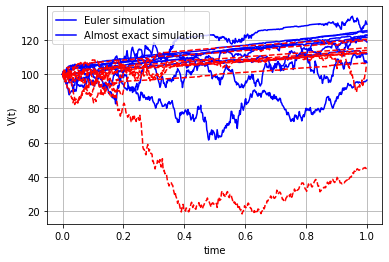

In [17]:
plt.figure(1)
plt.plot(timeGrid, np.transpose(S_Euler),'b')   
plt.plot(timeGrid, np.transpose(S_AES),'--r')   
plt.grid()
plt.xlabel("time")
plt.ylabel("V(t)")
plt.legend(['Euler simulation','Almost exact simulation']);  